In [39]:
!nvidia-smi

Fri Nov 22 20:27:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    77W / 149W |   5836MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
from google.colab import files
files.upload()

Saving udnie.jpg to udnie.jpg


{'udnie.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xdb\x00\x84\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc2\x00\x11\x08\x02\x00\x02\x00\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x01\x05\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x03\x04\x06\x07\x08\x02\x01\t\x00\xff\xda\x00\x08\x01\x01\x00\x00\x00\x00\xc4M}E\x15\x1d\x9eU\x8a\xfdw\xc2\xab~\xb6e\xcb\x16\xed\xa3\xa7\xb27\x85\x10:y\xafK\xfa\xa7\xe6\x8e\x19\xa9\xd3\xc8\xdcq\t\x91\\\xd5C\xad\xda_\x9b\xbbK\xc4\xfc+\xe2,\

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn

In [4]:
path = untar_data(URLs.PETS); path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_img = path/'images'

In [0]:
src = (ImageImageList.from_folder(path_img)
       .use_partial_data(0.3, seed=42)
       .split_by_rand_pct(0.1, seed=42))

In [0]:
bs,sz = 128,64
dbch = (src.label_from_func(lambda x: x)
        .transform(get_transforms(), tfm_y=True, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

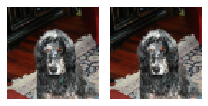

In [8]:
dbch.show_batch(rows=1, figsize=(3,3))

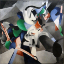

In [10]:
style_img = open_image('udnie.jpg').resize(sz)
style_timg = normalize(style_img.px, *map(tensor, imagenet_stats)).cuda()[None]; style_img

In [0]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw, stl_loss_mult=1e4):
        super().__init__()
        assert len(cnt_ls) == len(cnt_lsw)
        assert len(stl_ls) == len(stl_lsw)
        self.m_feat,self.cnt_ls,self.stl_ls,self.stl_loss_mult=m_feat,cnt_ls,stl_ls,stl_loss_mult
        self.cnt_lsw = tensor(cnt_lsw).float() / sum(cnt_lsw)
        self.stl_lsw = tensor(stl_lsw).float() / sum(stl_lsw)
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        self.metric_names = ['style', 'content']
        
    def register_style(self, timg):  _,self.stl_fs = self.get_fs(timg)

    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
        stl_loss = self.stl_loss_mult*self._stl_loss(pred_stl_fs)
        cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        self.metrics = dict(zip(self.metric_names, [stl_loss, cnt_loss]))
        return stl_loss + cnt_loss # Add a weight for each loss
        
    def _stl_loss(self, pred_fs):
        stl_loss = [base_loss(gram(pred_f),gram(style_f))*w**2*5e3
                    for pred_f,style_f,w in zip(pred_fs,self.stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w**2*5e3 for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [33]:
convs = [l for l in vgg_m.children() if isinstance(l,nn.Conv2d)]; len(convs)

13

In [0]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
bnecks = [vgg_m[i] for i in blocks]

In [0]:
fst_loss = FSTLoss(vgg_m, cnt_ls =bnecks[2:5], stl_ls= bnecks,
                          cnt_lsw=[5,15,2]   , stl_lsw=[1, 1, 1, 1])
fst_loss.register_style(style_timg)

In [36]:
fst_loss.cnt_lsw, fst_loss.stl_lsw

(tensor([0.2273, 0.6818, 0.0909]), tensor([0.3333, 0.3333, 0.3333]))

In [37]:
learn = unet_learner(dbch, models.resnet34, wd=1e-3, loss_func=fst_loss,
                     blur=True, norm_type=NormType.Spectral,
                     self_attention=True, y_range=(-3, 3)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 61.8MB/s]


In [38]:
learn.lr_find(); learn.recorder.plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([128, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(5, 3e-2, pct_start=.72)

epoch,train_loss,valid_loss,time
0,1.573250,1.445918,00:20
1,1.459543,1.334024,00:13
2,1.392430,1.341793,00:12
3,1.349456,1.245467,00:13
4,1.291112,1.163843,00:13


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([128, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target siz

In [0]:
# learn.unfreeze()
# learn.lr_find(); learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5, 5e-3))

epoch,train_loss,valid_loss,time
0,1.138325,1.120351,00:13
1,1.113077,1.058839,00:13
2,1.075155,0.989240,00:13
3,1.028563,0.911913,00:13
4,0.981015,0.861166,00:13
5,0.937373,0.818754,00:13
6,0.898815,0.789624,00:13
7,0.866529,0.777325,00:13
8,0.841450,0.772507,00:13
9,0.823155,0.771562,00:13


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([128, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target size (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([128, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Using a target siz

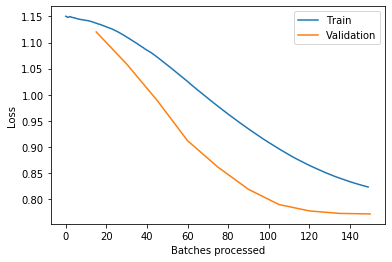

In [0]:
learn.recorder.plot_losses()

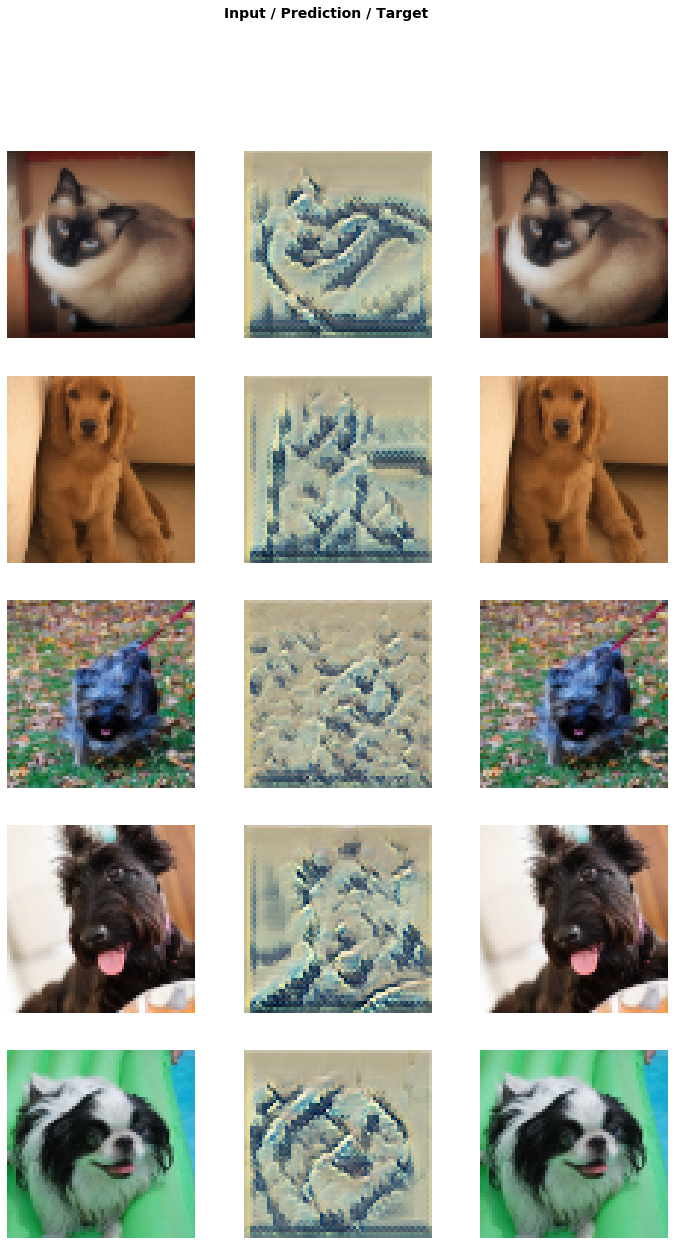

In [0]:
learn.show_results()

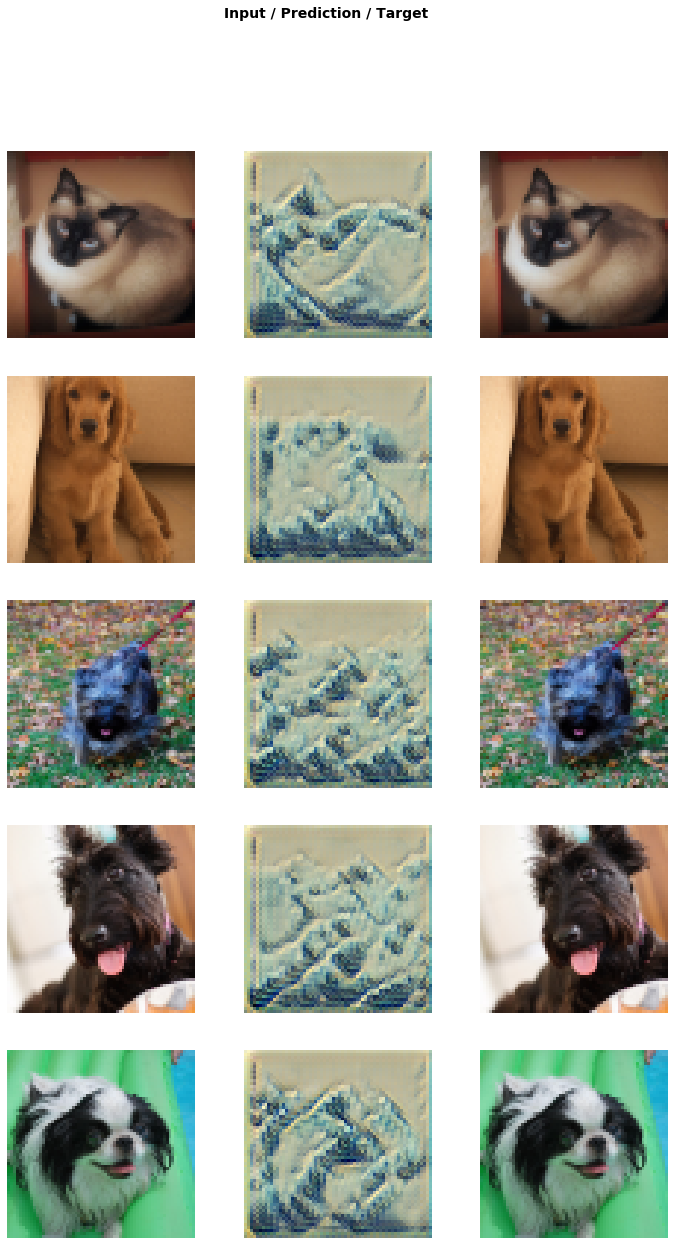

In [0]:
learn.show_results()

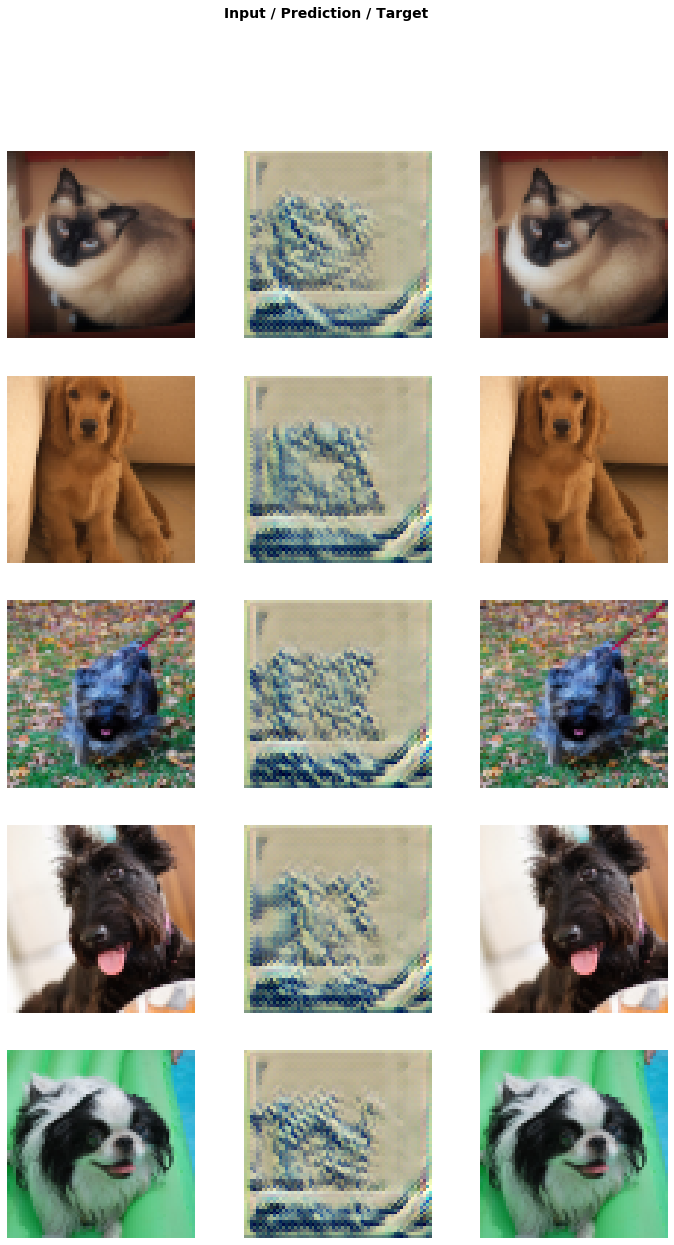

In [0]:
learn.show_results()